In [1]:
#%pip install torch torchvision fastai datasets pytorch-pretrained-biggan nltk torcheval
#%pip install pytorch-msssim
#%pip install numpy==1.26.4
# %pip install prun
## !pip install pandas
## !pip install scikit-learn
## !pip install fastai
## !pip install datasets
## !pip install torcheval

In [2]:
# get the python version
import sys
print(sys.version)
is_38 = sys.version_info >= (3, 8)


3.7.11 (default, Jul 27 2021, 14:32:16) 
[GCC 7.5.0]


In [3]:
import torch
import numpy as np
import os

from torchvision import datasets
from torchvision import transforms
import torchvision.transforms as T

import matplotlib.pyplot as plt
import pandas as pd

from numpy import genfromtxt

from PIL import Image

import random

# import visiondataset
from torchvision.datasets import VisionDataset
import pandas as pd

In [4]:
import pickle
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
import torch.nn.functional as F

class MyDataset(VisionDataset):
    def __init__(
        self,
        root: str = ".",
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        download: bool = False,
        normalize: Tuple[float, float] = None,
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)

        self.labels = [ 'tg', 'Ng', 'Pci', 'Ph', 'Ox', 'Ow', 'Hbt' ]
        self.ids, self.data, self.features = self._load_data(root, ij=normalize)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        return  self.data[index], torch.tensor(self.features.iloc[index])

    def __len__(self) -> int:
        return len(self.data)
    
    def _load_data(self, root: str, ij: Tuple[float, float]):
        ids = pd.read_csv(f'{root}/PD_ids_train.csv')
        data = pd.read_csv(f'{root}/PD_imgs_np_train.csv')
        features = pd.read_csv(f'{root}/PD_conditions_train.csv')

        # convert all to list
        # TODO something better than a list
        ids = ids.values.tolist()
        data = [ torch.tensor(d) for d in data.values.tolist() ]
        features = features.values.tolist()

        data = torch.stack(data)
        data = data[:, 1:]

        data = data.reshape(len(data), 140, 39).float()
        data = 2 * (data / 255) - 1

        #                                         [ 'tg', 'Ng', 'Pci', 'H', 'Wp', 'Ph', 'Ox', 'Ow', 'Hbt', 'Wm', 'Wr' ]
        features = pd.DataFrame(features, columns=[ 'tg', 'Ng', 'Pci', 'H', 'Wp', 'Ph', 'Ox', 'Ow', 'Hbt', 'Wm', 'Wr']).astype('float32')

        if ij is not None:
            # drop fields that are not used
            features = features.drop(columns=['H', 'Wp', 'Wm', 'Wr'])

            # NOTE: (-1, 1) => y = 2 * (x - min) / (max - min) - 1
            #       ( i, j) => y = (j-i) * (x - min) / (max - min) + i
            features = (ij[1] - ij[0]) * (features - features.min()) / (features.max() - features.min()) + ij[0]
            # NOTE: they are nan because the min and max are the same, std is 0 (and mean is normally NaN); so we can just set them to 0
            features = features.fillna(0)

        return ids, data, features

In [5]:
dataset = MyDataset(root='data')
# get the count, mean, std, min, max, and sum of each column
df_aggregated = dataset.features.agg(['count', 'mean', 'std', 'min', 'max', 'sum']).reset_index()
display(df_aggregated)

index             tg            Ng           Pci      H     Wp  \
0  count     668.000000    668.000000    668.000000  668.0  668.0   
1   mean     333.500000     68.757782     38.844311    0.0    0.0   
2    std     192.979279     52.810501     61.393608    0.0    0.0   
3    min       0.000000      0.000000      0.000000    0.0    0.0   
4    max     667.000000    200.000000    200.000000    0.0    0.0   
5    sum  222778.000000  45930.199219  25948.000000    0.0    0.0   

              Ph            Ox           Ow            Hbt           Wm  \
0     668.000000    668.000000   668.000000     668.000000   668.000000   
1     327.544922     25.612276     5.974551    1456.746948    12.199998   
2      61.626793      3.267343     2.021091      20.019705     0.000000   
3     300.000000     21.000000     3.000000    1410.000000    12.200000   
4     500.000000     30.000000     9.000000    1485.000000    12.200000   
5  218800.000000  17109.000000  3991.000000  973106.937500  8149.598633   

             Wr  
0  6.680000e+02  
1  3.087504e+05  
2  0.000000e+00  
3  3.087504e+05  
4  3.087504e+05  
5  2.062453e+08


data: tensor([[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.9922,  0.3020,  0.0353,  ...,  1.0000,  1.0000,  1.0000],
        [ 1.0000, -0.1608, -0.6314,  ...,  1.0000,  1.0000,  1.0000],
        ...,
        [ 1.0000,  0.4745,  0.2706,  ...,  1.0000,  1.0000,  1.0000],
        [ 1.0000,  0.9059,  0.8667,  ...,  1.0000,  1.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]])
features: tensor([-1.0000,  0.5000, -1.0000,  1.0000, -0.3333,  0.6667,  0.3280])



tg   Ng  Pci   Ph        Ox        Ow       Hbt
0 -1.0  0.5 -1.0  1.0 -0.333333  0.666667  0.328001

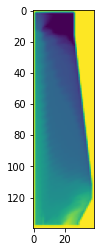

In [6]:
pixels = 16
dataset = MyDataset(root='data', normalize=(-1, 1))
datum = dataset[0]
print(f"""
data: {datum[0]}
features: {datum[1]}
""")

# convert data to image plot
# TODO first pixel is bad
img = np.array(datum[0])
plt.imshow(img)

# img = img.reshape(-1, 128, 128)
# img = Image.fromarray((img * 255).astype(np.uint8)[0])
# plt.imshow(img)
# img2 = np.array(datum[0])
# img2 = img2[:-16].reshape(140, 39)
# plt.imshow(img2)

# downscale to 74x74
# remove the padding
# img = img[:-4].reshape(-1, 140, 39*3)
# img = img.reshape(-1, pixels, pixels)
# # img = F.interpolate(torch.Tensor(img).unsqueeze(0), size=(140, 39), mode='nearest').squeeze(0).numpy()
# print(img.shape)
# img = Image.fromarray((img * 255).astype(np.uint8)[0])
# plt.imshow(img)

conditions = np.array(datum[1])
features = pd.DataFrame([conditions], columns=dataset.labels)
display(features)

In [7]:
# get the count, mean, std, min, max, and sum of each column
df_aggregated = dataset.features.agg(['count', 'mean', 'std', 'min', 'max', 'sum']).reset_index()
display(df_aggregated)

# remove the tg column from the dataset
# dataset.features = dataset.features.drop(columns=['tg'])

index            tg          Ng         Pci          Ph          Ox  \
0  count  6.680000e+02  668.000000  668.000000  668.000000  668.000000   
1   mean -2.284250e-08   -0.312422   -0.611557   -0.724551    0.024950   
2    std  5.786485e-01    0.528105    0.613936    0.616268    0.726076   
3    min -1.000000e+00   -1.000000   -1.000000   -1.000000   -1.000000   
4    max  1.000000e+00    1.000000    1.000000    1.000000    1.000000   
5    sum -1.525879e-05 -208.697998 -408.519989 -484.000000   16.666679   

           Ow         Hbt  
0  668.000000  668.000000  
1   -0.008483    0.246588  
2    0.673697    0.533859  
3   -1.000000   -1.000000  
4    1.000000    1.000000  
5   -5.666660  164.720627

In [8]:
# get the memory usage so far
print(f"Memory usage: {dataset.features.memory_usage().sum()} bytes")

Memory usage: 18832 bytes


# CGAN

In [9]:

import torch
import numpy as np
import os

from torchvision import datasets
from torchvision import transforms
import torchvision.transforms as T

import matplotlib.pyplot as plt
import pandas as pd

from numpy import genfromtxt

from PIL import Image

import random

# import visiondataset
from torchvision.datasets import VisionDataset

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [11]:

from torch.utils.data import TensorDataset, DataLoader

import torch.optim as optim 
import torch.nn as nn


import torch.nn.functional as F

from torch.autograd import Variable

from fastai.vision.all import *
from fastai.vision.gan import *

from fastai.callback.all import *

In [12]:
from datasets import load_dataset, Split
import torch.autograd as autograd
from torcheval.metrics import PeakSignalNoiseRatio

In [13]:
channels = 1 ## 1 for B&W, 3 for RGB, 4 for RGBA

learning_rate    = 2e-4 #0.003  ## Adam default   ## 0.001 2e-4#
batch_size       = 16
N_Epochs         = 700 #4_000  ##27000  
num_classes = 1
width = 39
height = 140
img_size = width*height*channels
certainty_repeater = 6# channels**2 - num_classes

print(f"{img_size}")

if torch.cuda.is_available():
    device = torch.device('cuda')
    # get number of cuda devices
    print(f"devices: {torch.cuda.device_count()}")
    print(f"device:  {torch.cuda.get_device_name()}")
    print(f"device0: {torch.cuda.get_device_properties(0)}")
    print(f"{torch.cuda.memory_summary()}")
elif torch.backends.mps is not None:
    device = torch.device('mps')
    print(f"{torch.mps.current_allocated_memory()}")
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
else:
    device = torch.device('cpu')
    # print a warning that cpu is being used
    print("Warning: Running on CPU. This will be slow.")
print(f"{device}")

5460
devices: 1
device:  NVIDIA GeForce RTX 2080 Ti
device0: _CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11010MB, multi_processor_count=68)
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|-----------------------------------

In [14]:
# convert the dataset into a train / test split
# TODO i dont think test is used
# need to keep the split for each new run, to continue the epochs and same data
# TODO keep this, nicer, or use seed as file label

##################################################

dataset_size = len(dataset)
train_size   = int(0.85 * dataset_size)
test_size    = dataset_size - train_size  # ensures full coverage

train_dataset, test_dataset = torch.utils.data.random_split(
    dataset,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)
)


# define the dataloader
dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [15]:

def plot_GAN_losses(losses: List[Tuple[float, float]]):
    losses_generator = [i[0] for i in losses]
    losses_critic = [i[1] for i in losses]

    n_epochs = [i for i in range(len(losses))]  

    plt.plot(n_epochs, losses_critic,      label = "critic") 
    plt.plot(n_epochs, losses_generator,  label = "generator")
    plt.legend() 
    plt.show()


In [16]:

def print_metrics_function(y_test, y_pred):
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print("Confusion Matrix:")
    print(confmat)
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    f1_measure = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    print('F1-mesure: %.3f' % f1_measure)
    return f1_measure, confmat


In [17]:
def plot_metric_per_epoch(the_scores_list):
    # metrics = {}
    # metrics = []
    print(the_scores_list[0])
    epochs = [ the_scores_list['epoch'] for metric in the_scores_list ]
    for metric in the_scores_list:
        test = [ the_scores_list[metric] for metric in the_scores_list ]

    # x_epochs = []
    # y_epochs = [] 
    # for i, val in enumerate(the_scores_list):
    #     x_epochs.append(i)
    #     y_epochs.append(val)
    
        plt.scatter(epochs, test ,s=50,c='lightgreen', marker='s', label='score')
        plt.xlabel('epoch')
        plt.ylabel('score')
        plt.title('Score per epoch')
        plt.legend()
        plt.grid()
        plt.show()

In [18]:
def get_metrics(epoch):
    # using train_dl each time anywhere will give different values each time
    test = [ x for x in test_dataset ]

    real = torch.stack([x[0] for x in test], dim=0).to(device).unsqueeze(1)

    labels = torch.stack([x[1] for x in test], dim=0).to(device)
    labels = labels.repeat(1, 3).to(device)

    rand = noise_batch(len(real)).to(device)
    noise = torch.cat( (rand, labels) , dim=1)
    fake = G_model.forward( noise )

    psnr = PeakSignalNoiseRatio(device=device)
    psnr.update(fake, real)

    real = real.detach().cpu()
    fake = fake.detach().cpu()
    labels = labels.detach().cpu()

    metric = {
        'sanity': labels[0], # should always be the same
        'epoch': epoch,
    }

    return metric, fake

In [19]:
def random_G_vector_input():
    rand_vec = torch.randn( 100 ).to(device)
    return rand_vec

In [20]:
def noise_batch(batch_size=None):
    if batch_size is None:
        return torch.randn(100).to(device)
    else:
        return torch.randn(batch_size, 100).to(device)

In [21]:
def random_G_batch_vector_input():
    rand_vec = torch.randn( (batch_size, 100 ) ).to(device)
    return rand_vec

In [22]:
def random_batch_one_hot_rc(batch_size, size):
    rand_vec = torch.zeros( (batch_size, num_classes ) ).to(device)
    for i in range(batch_size):
        random_idx = random.randint(0,size-1)
        rand_vec[i, random_idx] = 1.0
    return rand_vec

In [23]:
import datetime
import tqdm

losses = []
metrics = []
fakes = []

def training_loop(N_Epochs, G_model, D_model, D_loss_fn, G_opt, D_opt,
                  checkpoint='checkpoint', save_interval: int = None, stop_after: datetime.timedelta = None, start_epoch: int = None):
    global losses
    global metrics
    global fakes
    
    if start_epoch is not None:
        G_model.load_state_dict(torch.load(f"{checkpoint}/G_{start_epoch}.pt"))
        D_model.load_state_dict(torch.load(f"{checkpoint}/D_{start_epoch}.pt"))
        losses = torch.load(f"{checkpoint}/l_{start_epoch}.pkl")
        metrics = torch.load(f"{checkpoint}/m_{start_epoch}.pkl")
        fakes = torch.load(f"{checkpoint}/f_{start_epoch}.pkl")
        
        print(f"loaded {checkpoint}/*_{start_epoch}")
    else:
        start_epoch = 0
    
    start_time = datetime.datetime.now()
    last_time = datetime.datetime.min
    pbar = tqdm.tqdm(range(start_epoch, N_Epochs+1))
    # pbar.update(start_epoch) # update with start makes it double. only one does nothing
    
    # TODO pbar jump to start
    for epoch in pbar:
        # shuffle dl_train every epoch
        # dataset = MyDataset(root='data', normalize=(-1, 1), transform=transforms.Compose([
        #     transforms.RandomHorizontalFlip(),
        #     transforms.RandomVerticalFlip()
        # ]))
        # train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.95, 0.05])
        dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        for xb, yb in dl_train:              ## xb = [batch, 1, 28, 28]
            xb, yb = xb.to(device), yb.to(device)
            # print the memory usage of mps

            if xb.shape[0] != batch_size:
                # print(f"skipping batch of size {xb.shape[0]}")
                continue

            # xb = xb.reshape(batch_size, 128, width)
            # xb = F.pad(xb, (0, 128-width, 0, 0), value=-1) # TODO set to min
            yb = yb.repeat(1, 3)
            xb = torch.unsqueeze(xb, dim=1)
            # pad the image to 140x140
            # convert nb [batch, 384] to [batch, -1, 32, channels]

            yb_certainty = yb.repeat(channels, 140, 1, 1).permute(2, 0, 1, 3)#1, 0, 2) # [ batch, x (classes), y, channels ]
            real = torch.cat( (xb, yb_certainty) , dim=3)
            # print the real image
            # plt.imshow(real[0].squeeze(0).cpu().detach().numpy())

            # print the real image TODO this will print nothing because it is normalized to highest number
            # plt.imshow(real[0].squeeze(0).cpu().detach().numpy())

            for _ in range(5):
                noise = torch.cat( (random_G_batch_vector_input(), yb) , dim=1)
                fake = G_model( noise )#.detach()
                real_pred = D_model( real  ).reshape(-1)
                inputs = torch.cat( (fake, yb_certainty) , dim=3)
                fake_pred = D_model(  inputs  ).reshape(-1)

                fake_loss   = D_loss_fn(D_model, inputs, real, real_pred, fake_pred)
                # D_opt.zero_grad()
                D_model.zero_grad()
                fake_loss.backward(retain_graph=True)
                D_opt.step()
                
            output = D_model( inputs ).reshape(-1)
            gen_loss = -torch.mean(output)
            G_model.zero_grad()
            gen_loss.backward()
            G_opt.step()


        if epoch % 1 == 0:
            loss = (
                gen_loss.cpu().detach().numpy(),
                fake_loss.cpu().detach().numpy()
            )
            losses.append(loss)
            D_gen_loss_rnd = np.round(loss[0], 3)
            D_fake_loss_rnd = np.round(loss[1], 3)

            # not rounded anymore :(
            message = f"gen: {D_gen_loss_rnd}; crit: {D_fake_loss_rnd}"
            pbar.set_description(message)
            
        # draw an image of each class
        # place them all on the same figure
        # if epoch % 100 == 0:
        if datetime.datetime.now() > last_time + datetime.timedelta(minutes=10):
            last_time = datetime.datetime.now()
            f, axarr = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
            
            for i in range(2):
                label = dataset[i][1].unsqueeze(0).repeat(1, 3).to(device)

                # create noise and make it 2d
                noise = random_G_vector_input().unsqueeze(0)
                inputs = torch.cat( (noise, label) , dim=1)
                output = G_model( inputs ).squeeze(0).cpu()
                
                img = output.detach().numpy()

                img = Image.fromarray(img[0], mode='L')
                # display the image
                # (1, 16, 16) => (16, 16)
                
                axarr[i].imshow(img)

                # show the original image
                img = dataset[i][0].cpu().detach().numpy()
                axarr[i+2].imshow(Image.fromarray(img, mode='L'))

            # save the plot
            plt.savefig(f"{checkpoint}/epoch_{epoch}.png")
            plt.show()
            
            metric, fake = get_metrics(epoch)
            metrics.append(metric)
            fakes.append(fake)
        
        if save_interval is not None and epoch % save_interval == 0:
            torch.save(G_model.state_dict(), f"{checkpoint}/G_{epoch}.pt")
            torch.save(D_model.state_dict(), f"{checkpoint}/D_{epoch}.pt")
            
            torch.save(losses, f"{checkpoint}/l_{epoch}.pkl")
            torch.save(metrics, f"{checkpoint}/m_{epoch}.pkl")
            torch.save(fakes, f"{checkpoint}/f_{epoch}.pkl")
        
        if stop_after is not None and datetime.datetime.now() > start_time+stop_after:
            print(f"Stopping training because it has been {datetime.datetime.now() - start_time} since {start_time}")
            break

    torch.save(G_model.state_dict(), f"{checkpoint}/G_{epoch}.pt")
    torch.save(D_model.state_dict(), f"{checkpoint}/D_{epoch}.pt")
    torch.save(losses, f"{checkpoint}/l_{epoch}.pkl")
    torch.save(metrics, f"{checkpoint}/m_{epoch}.pkl")
    torch.save(fakes, f"{checkpoint}/f_{epoch}.pkl")

In [24]:
def grad_penatly(critic, real, fake):
    # Random weight term for interpolation between real and fake samples
    batch, c, h, w = real.shape
    epsilon = torch.rand((batch, 1, 1, 1)).repeat(1, c, h, w).to(device)
    interpolated_images = real * epsilon + fake * (1 - epsilon)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Take the norm of the gradient
    gradient = gradient.view(gradient.shape[0], -1)
    grad_norm = gradient.norm(2, dim=1) # L2 norm (euclidean norm)
    gradient_penalty = torch.mean((grad_norm - 1) ** 2)
    return gradient_penalty

def wasserstein_loss(D_model, gen_img, real_data, real_pred, fake_pred):
    loss =  - (real_pred.mean() - fake_pred.mean()) + 10 * grad_penatly(D_model, real_data, gen_img)
    return loss

In [28]:
class ModifiedGenerator(nn.Module):
    def __init__(self, size, in_sz, channels, extra_layers):
        super().__init__()
        self.basic_gen = basic_generator(size, in_sz=in_sz, n_channels=channels, n_extra_layers=extra_layers)
        # Remove the final layer and add adaptive ones
        self.basic_gen.final_layer = nn.Identity()
        
        # Add custom final layers
        self.adaptive_conv = nn.ConvTranspose2d(1, 32, 4, 2, 1)
        self.final_conv = nn.Conv2d(32, 1, 3, 1, 1)
        # self.adaptive_pool = nn.AdaptiveAvgPool2d((39, 140)) # Adaptive pool MPS: input sizes must be divisible by output sizes.
        self.active = nn.Tanh()
        
    def forward(self, z):
        x = self.basic_gen(z)  # Gets you to ~128×128
        x = self.adaptive_conv(x)
        x = self.final_conv(x)
        # x = self.adaptive_pool(x)  # Force exact dimensions
        x = F.interpolate(x, size=(140, 39), mode='bilinear', align_corners=False)
        x = self.active(x)

        return x

gen: 7.817999839782715; crit: -10.930999755859375:   0%|                                                                                                                            | 0/701 [00:24<?, ?it/s]

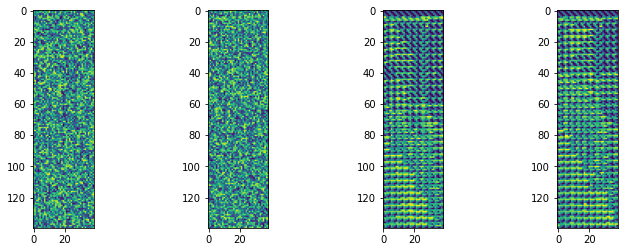

gen: -154.02699279785156; crit: -3.2750000953674316:   3%|███▊                                                                                                           | 24/701 [10:33<4:48:36, 25.58s/it]

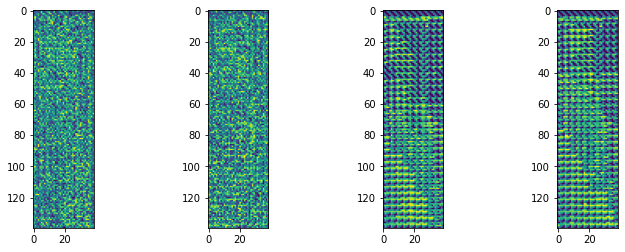

gen: -64.7020034790039; crit: -1.2330000400543213:   7%|███████▋                                                                                                         | 48/701 [20:52<4:41:13, 25.84s/it]

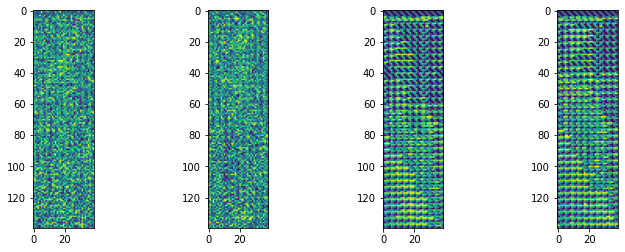

gen: -26.70400047302246; crit: -1.2389999628067017:  10%|███████████▌                                                                                                    | 72/701 [31:14<4:31:30, 25.90s/it]

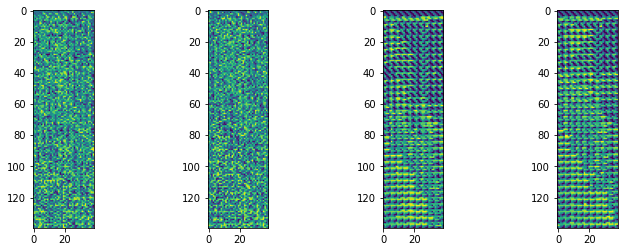

gen: -14.083999633789062; crit: -1.0099999904632568:  14%|███████████████▏                                                                                               | 96/701 [41:36<4:20:53, 25.87s/it]

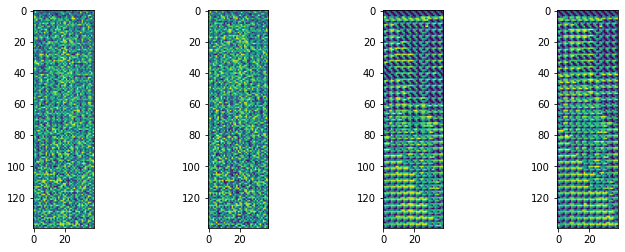

gen: -7.3379998207092285; crit: -0.7870000004768372:  17%|██████████████████▊                                                                                           | 120/701 [51:58<4:11:03, 25.93s/it]

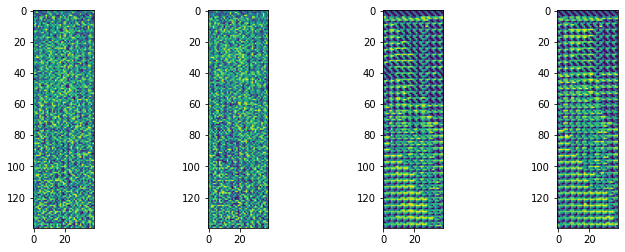

gen: -2.566999912261963; crit: -0.9610000252723694:  21%|██████████████████████▍                                                                                      | 144/701 [1:02:21<4:00:58, 25.96s/it]

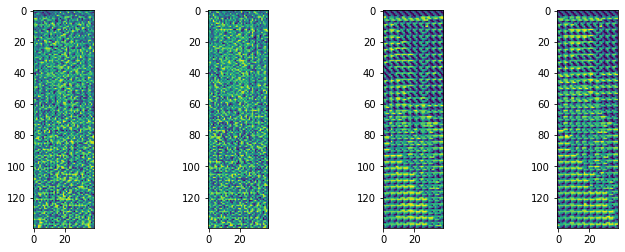

gen: -2.8380000591278076; crit: -0.9440000057220459:  24%|█████████████████████████▉                                                                                  | 168/701 [1:12:45<3:51:00, 26.00s/it]

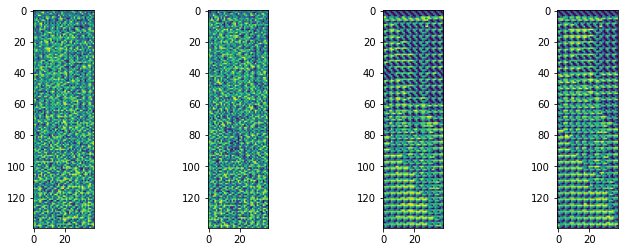

gen: -1.3300000429153442; crit: -0.8149999976158142:  27%|█████████████████████████████▌                                                                              | 192/701 [1:23:09<3:40:42, 26.02s/it]

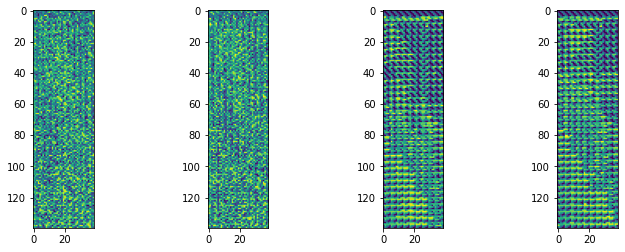

gen: -0.3160000145435333; crit: -0.4869999885559082:  31%|█████████████████████████████████▎                                                                          | 216/701 [1:33:34<3:30:08, 26.00s/it]

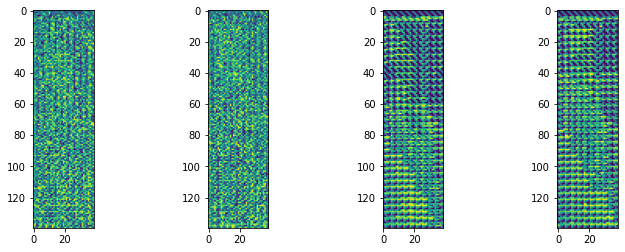

gen: 1.3170000314712524; crit: -0.3190000057220459:  34%|█████████████████████████████████████▎                                                                       | 240/701 [1:43:58<3:19:14, 25.93s/it]

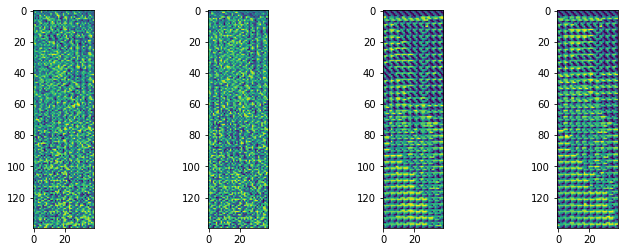

gen: 18.26300048828125; crit: -0.8980000019073486:  38%|█████████████████████████████████████████▍                                                                    | 264/701 [1:54:20<3:08:50, 25.93s/it]

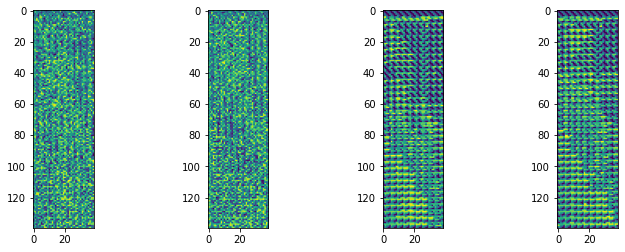

gen: 17.913000106811523; crit: -0.6159999966621399:  41%|████████████████████████████████████████████▊                                                                | 288/701 [2:04:44<2:58:51, 25.99s/it]

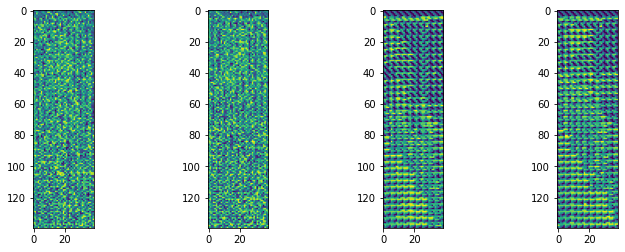

gen: 18.048999786376953; crit: -0.5220000147819519:  45%|████████████████████████████████████████████████▌                                                            | 312/701 [2:15:07<2:48:12, 25.94s/it]

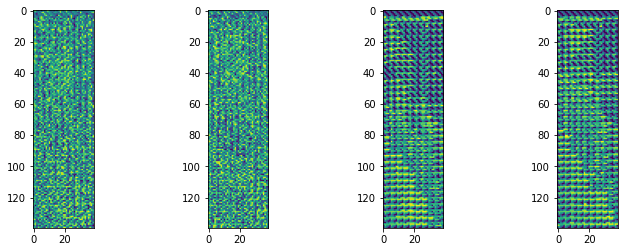

gen: 18.038000106811523; crit: -0.460999995470047:  48%|████████████████████████████████████████████████████▋                                                         | 336/701 [2:25:30<2:37:44, 25.93s/it]

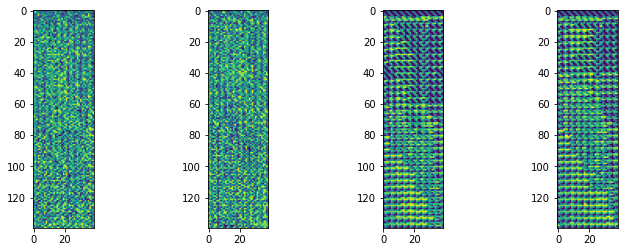

gen: 19.0049991607666; crit: -0.49000000953674316:  51%|████████████████████████████████████████████████████████▍                                                     | 360/701 [2:35:53<2:27:20, 25.93s/it]

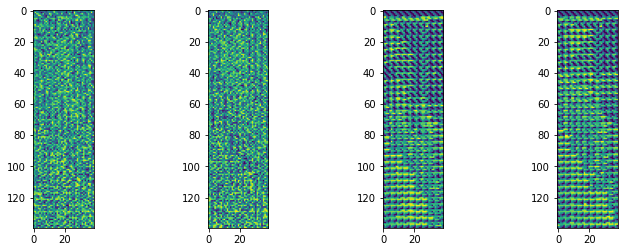

gen: 17.89299964904785; crit: -0.3330000042915344:  55%|████████████████████████████████████████████████████████████▎                                                 | 384/701 [2:46:16<2:17:14, 25.98s/it]

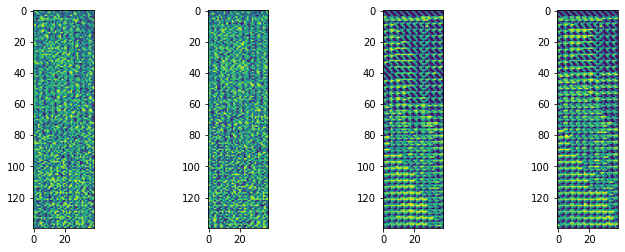

gen: 16.610000610351562; crit: -0.4169999957084656:  58%|███████████████████████████████████████████████████████████████▍                                             | 408/701 [2:56:40<2:06:41, 25.94s/it]

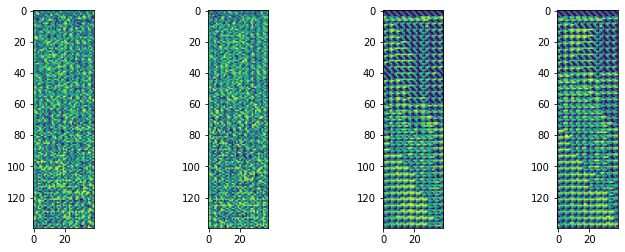

gen: 16.033000946044922; crit: -0.4959999918937683:  62%|███████████████████████████████████████████████████████████████████▏                                         | 432/701 [3:07:02<1:56:09, 25.91s/it]

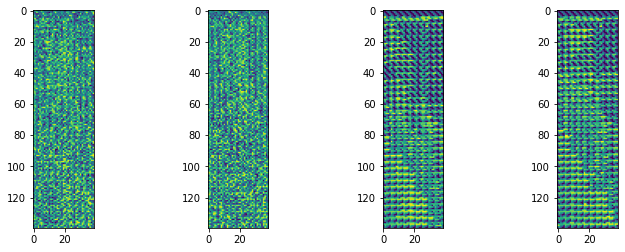

gen: 13.696999549865723; crit: -0.27399998903274536:  65%|██████████████████████████████████████████████████████████████████████▎                                     | 456/701 [3:17:24<1:45:42, 25.89s/it]

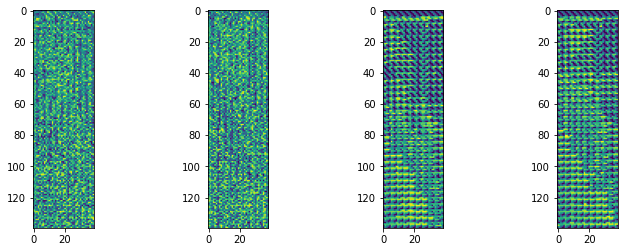

gen: 13.529000282287598; crit: -0.2290000021457672:  68%|██████████████████████████████████████████████████████████████████████████▋                                  | 480/701 [3:27:45<1:35:17, 25.87s/it]

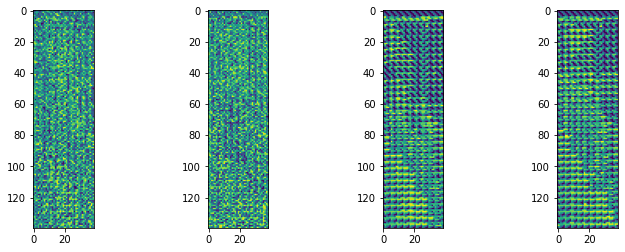

gen: 11.446999549865723; crit: -0.21699999272823334:  72%|█████████████████████████████████████████████████████████████████████████████▋                              | 504/701 [3:38:06<1:24:53, 25.86s/it]

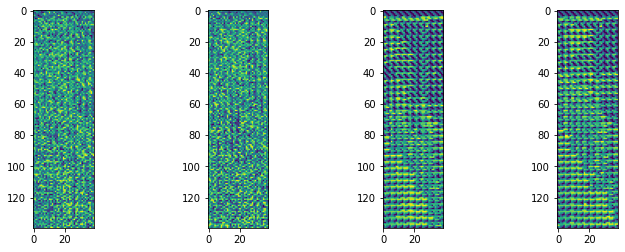

gen: 9.729999542236328; crit: -0.24699999392032623:  75%|██████████████████████████████████████████████████████████████████████████████████                           | 528/701 [3:48:27<1:14:31, 25.85s/it]

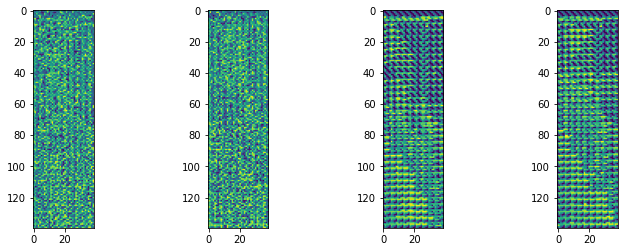

gen: 8.99899959564209; crit: -0.27799999713897705:  79%|██████████████████████████████████████████████████████████████████████████████████████▌                       | 552/701 [3:58:47<1:04:08, 25.83s/it]

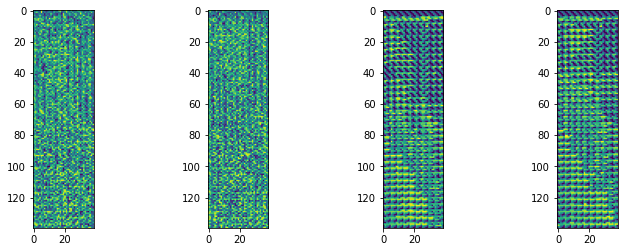

gen: 8.461999893188477; crit: -0.24199999868869781:  82%|███████████████████████████████████████████████████████████████████████████████████████████▏                   | 576/701 [4:09:08<53:48, 25.83s/it]

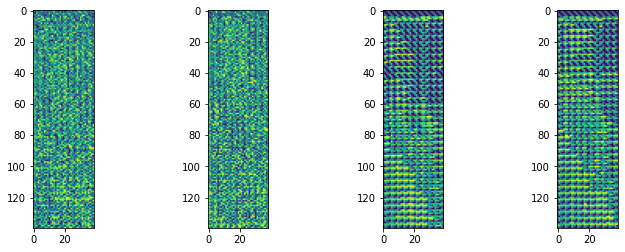

gen: 6.670000076293945; crit: -0.2630000114440918:  86%|███████████████████████████████████████████████████████████████████████████████████████████████▊                | 600/701 [4:19:28<43:28, 25.82s/it]

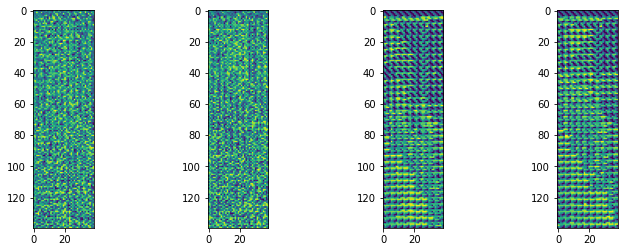

gen: 6.105000019073486; crit: -0.3019999861717224:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████▋            | 624/701 [4:29:48<33:08, 25.83s/it]

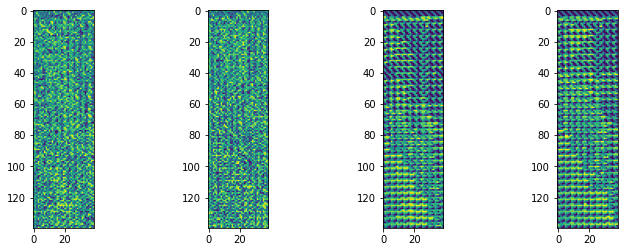

gen: 5.591000080108643; crit: -0.27799999713897705:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 648/701 [4:40:08<22:49, 25.83s/it]

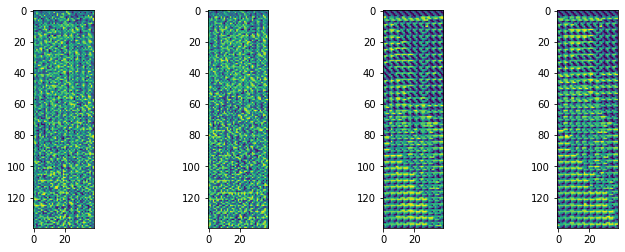

gen: 5.179999828338623; crit: -0.35100001096725464:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 672/701 [4:50:29<12:29, 25.83s/it]

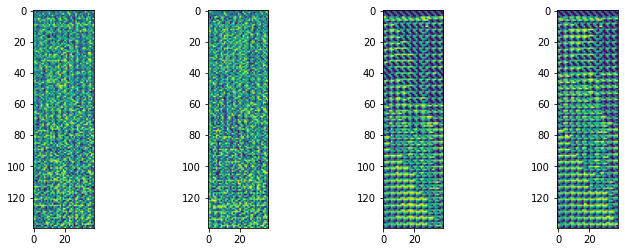

gen: 4.704999923706055; crit: -0.1979999989271164:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 696/701 [5:00:49<02:09, 25.84s/it]

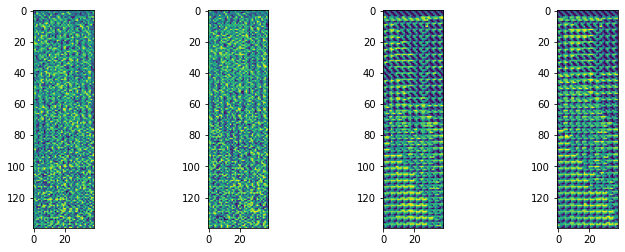

gen: 4.824999809265137; crit: -0.23499999940395355: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 701/701 [5:02:33<00:00, 25.90s/it]


In [29]:
G_model     =  ModifiedGenerator(128, in_sz=100+7*3, channels=channels, extra_layers=1)

#import resnet 50
from torchvision.models import resnet50

# TODO storing it wrong. maybe see how they compare. something odd in it
# TODO but not that other thing. makes no sense. wouldnt even matter. and it works without
# maybe watch xb stuff
D_model = resnet50(pretrained=True)

# make resnet input same channels
D_model.conv1 = torch.nn.Conv2d(channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# # Replace maxpool with avgpool (used to work without this, might be MPS thing)
D_model.maxpool = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
# make resnet output 2 classes
D_model.fc = torch.nn.Linear(in_features=2048, out_features=2, bias=True)

D_loss_fn = wasserstein_loss

G_opt       = torch.optim.Adam( G_model.parameters(), lr=learning_rate, betas=(0.0, 0.9) )
D_opt       = torch.optim.Adam( D_model.parameters(), lr=learning_rate, betas=(0.0, 0.9) )

# move everything to device
G_model.to(device)
D_model.to(device)

training_loop(  N_Epochs, G_model, D_model, D_loss_fn, G_opt, D_opt, 
              checkpoint='checkpoint', save_interval=100, stop_after=None, start_epoch=None  )

# Validation

loaded checkpoint/G_700.pt


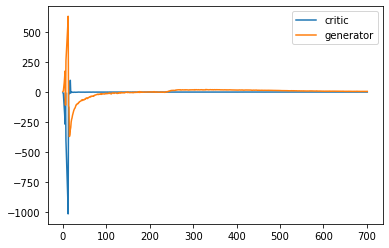

30 101


In [30]:
def last_checkpoint(starter: str):
    return max([ f"checkpoint/{f}" for f in os.listdir('checkpoint') if f.startswith(starter) ], key=os.path.getctime)

G_model     =  ModifiedGenerator(128, in_sz=100+7*3, channels=channels, extra_layers=1).to(device)

# get the checkpoint with the latest date
checkpoint = last_checkpoint('G_')

# G_692 - basic, 128
G_model.load_state_dict(torch.load(f"{checkpoint}", map_location=torch.device(device)))
print(f"loaded {checkpoint}")

losses = torch.load(last_checkpoint('l_'))
plot_GAN_losses(losses)

metrics = torch.load(last_checkpoint('m_'))
# plot_metric_per_epoch(metrics)

fakes = torch.load(last_checkpoint('f_'))
print(len(fakes), len(fakes[0]))
# print(metrics)

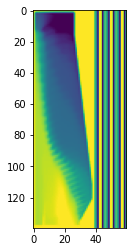

In [31]:
test = [ x for x in test_dataset ] 

xb = torch.Tensor(test[0][0]).to(device).unsqueeze(0)

yb = torch.Tensor(test[0][1]).repeat(1, 3).to(device)

yb_certainty = yb.repeat(channels, 140, 1)#1, 0, 2) # [ batch, x (classes), y, channels ]
# yb_certainty = nb.reshape(batch_size, channels, pixels, -1)
real = torch.cat( (xb, yb_certainty) , dim=2)

plt.imshow(real.cpu().numpy()[0])

tensor([ 0.4483, -0.1000, -1.0000,  1.0000,  1.0000, -1.0000,  0.3280,  0.4483,
        -0.1000, -1.0000,  1.0000,  1.0000, -1.0000,  0.3280,  0.4483, -0.1000,
        -1.0000,  1.0000,  1.0000, -1.0000,  0.3280], device='cuda:0')


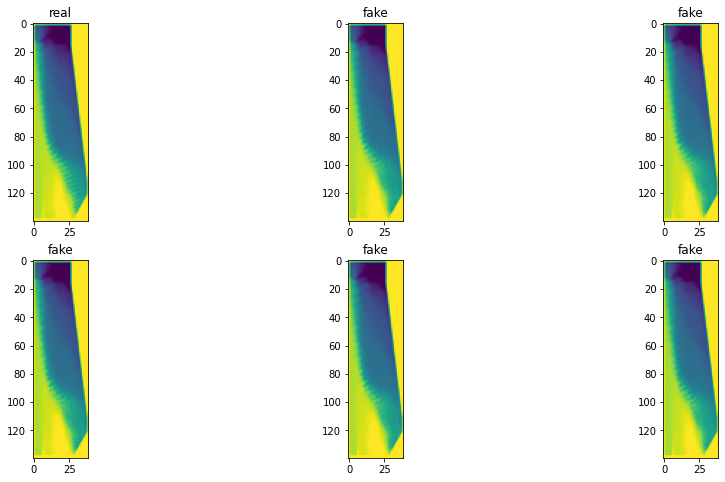

In [32]:
f, axarr = plt.subplots(2,3, figsize=(16,8))

test = [ x for x in test_dataset ] 

real = torch.Tensor(test[0][0]).to(device)

labels = torch.Tensor(test[0][1]).repeat(1, 3).to(device)

print(labels[0])
for i in range(2):
    for j in range(3):
        if i == 0 and j == 0:
            img = real.detach().cpu().numpy()
        else:
            rand = random_G_vector_input().unsqueeze(0)
            
            label = labels[0].to(device).unsqueeze(0)
            noise = torch.cat( (rand, label) , dim=1)
            fake = G_model.forward( noise ).cpu()
            img = fake.squeeze().squeeze().detach().numpy()

        # img = Image.fromarray((img * 255).astype(np.uint8), mode='L')
        # display the image
        # plt.imshow(img)
        axarr[i,j].set_title("real" if i == 0 and j == 0 else "fake")
        axarr[i,j].imshow(img)#, interpolation='none', cmap='Blues'

        # TODO print comparison

In [36]:

## !pip install pytorch_msssim


In [37]:

from torcheval.metrics import PeakSignalNoiseRatio
from torcheval.metrics.image import FrechetInceptionDistance
from pytorch_msssim import ssim, ms_ssim

# fid = FrechetInceptionDistance(device=device)

# Generate some dummy data (replace with your real and generated images)
rand = random_G_vector_input().unsqueeze(0)
label = dataset[0][1].to(device).unsqueeze(0).repeat(1, 3)
noise = torch.cat( (rand, label) , dim=1)
fake = G_model.forward( noise )
print(fake.shape)

real = dataset[0][0].cuda()
print(real.shape)

torch.Size([1, 1, 140, 39])
torch.Size([140, 39])


checkpoint/700


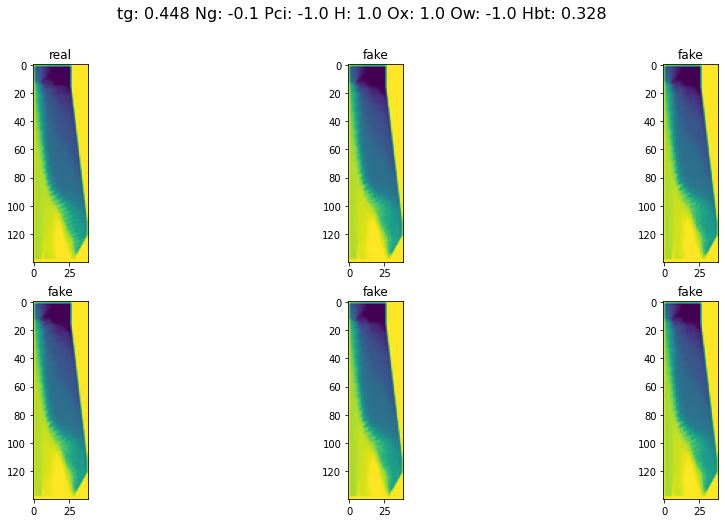

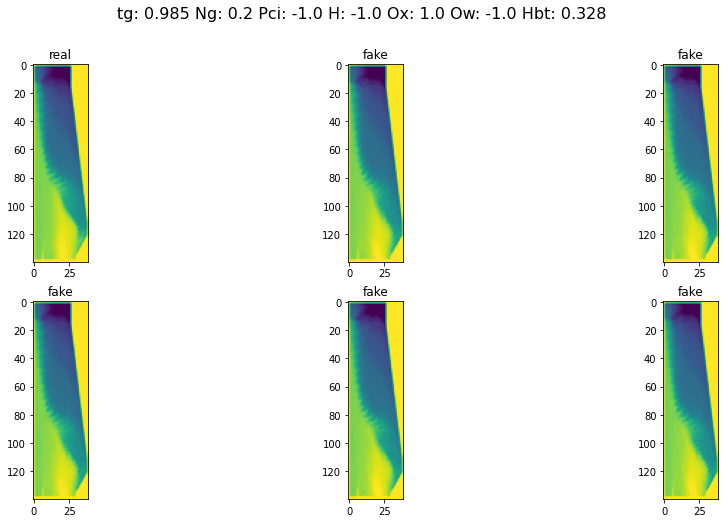

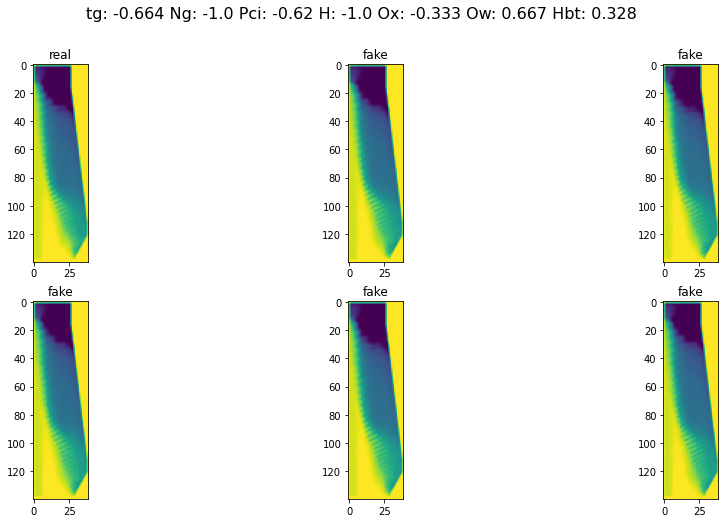

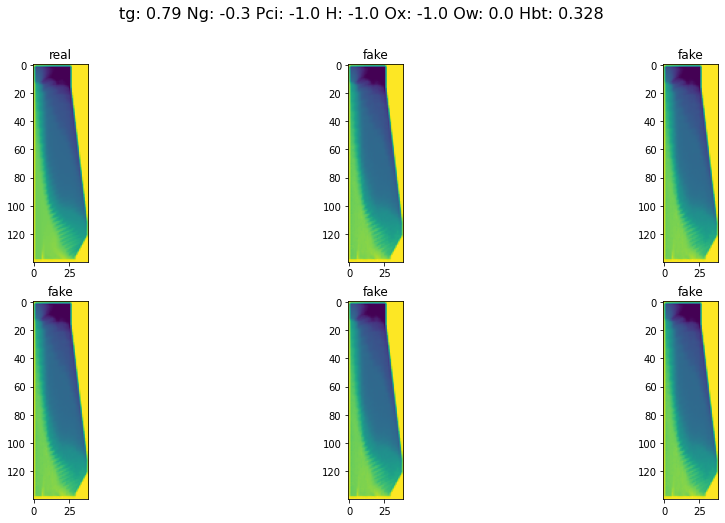

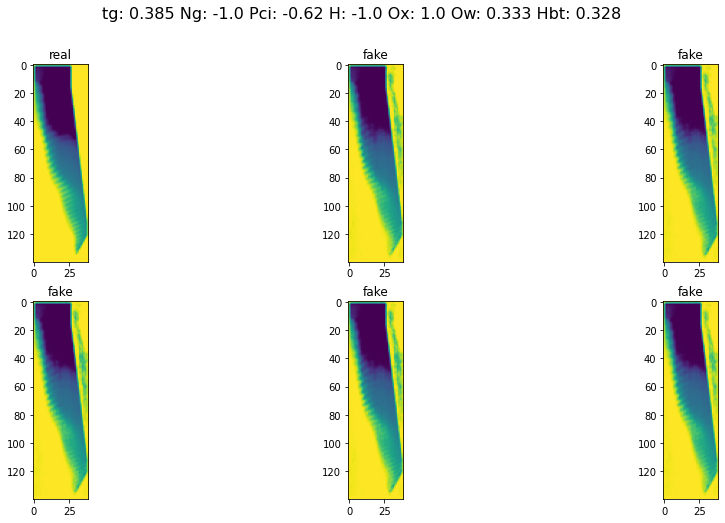

In [38]:
feats = [ 'tg', 'Ng', 'Pci', 'H', 'Ox', 'Ow', 'Hbt' ]
test = [ x for x in test_dataset ]

epoch = checkpoint.split('.')[0].replace('G_','')
print(epoch)

for k in range(5):
    f, axarr = plt.subplots(2,3, figsize=(16,8))

    real = torch.Tensor(test[k][0]).unsqueeze(0).to(device)
    labels = torch.Tensor(test[k][1]).repeat(1, 3).to(device)

    for i in range(2):
        for j in range(3):
            if i == 0 and j == 0:
                img = real.detach().cpu().numpy()
            else:
                rand = random_G_vector_input().unsqueeze(0)

                label = labels[0].to(device).unsqueeze(0)
                noise = torch.cat( (rand, label) , dim=1)
                fake = G_model.forward( noise ).cpu()
                img = fake.squeeze(0).detach().numpy()

                img = img
            # img = Image.fromarray((img * 255).astype(np.uint8)[0], mode='L')
            # display the image
            # plt.imshow(img)
            axarr[i,j].set_title("real" if i == 0 and j == 0 else "fake")
            axarr[i,j].imshow(img[0])

    # the title is the names of the features and the value of them (label and remove the repeat)
    f.suptitle(' '.join([ f"{f}: {round(l.item(), 3)}" for f, l in zip(feats, labels[0][:len(feats)]) ]), fontsize=16)
    plt.savefig(f"{epoch}-{k}.png")

# # Adjust the layout and save
# plt.tight_layout()
# f.savefig("test.png", dpi=300, bbox_inches='tight')

TypeError: __init__() got an unexpected keyword argument 'weights'

In [41]:

import torchvision.models as models
import torch.nn as nn
from torcheval.metrics import FrechetInceptionDistance

# Older torchvision doesn't support weights, so use pretrained
inception = models.inception_v3(pretrained=True)
inception.fc = nn.Identity()
fid = FrechetInceptionDistance(model=inception)

# Dummy example
import torch
real = torch.rand(64, 3, 299, 299)
fake = torch.rand(64, 3, 299, 299)

fid.update(real, is_real=True)
fid.update(fake, is_real=False)

print(fid.compute())




Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /home/maquina1/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

tensor(4.1842)


In [47]:
test = [ x for x in test_dataset ]
print(len([x[0] for x in test]), type(test[0][0]))

real = torch.stack([x[0] for x in test], dim=0).to(device)
print(real.shape, len(real))
real = real

labels = torch.stack([x[1] for x in test], dim=0).to(device)
print(labels.shape, len(labels))
labels = labels.repeat(1, 3).to(device)

rand = noise_batch(len(real)).to(device)
noise = torch.cat( (rand, labels) , dim=1)
fake = G_model.forward( noise )

101 <class 'torch.Tensor'>
torch.Size([101, 140, 39]) 101
torch.Size([101, 7]) 101


In [48]:
test = [ x for x in test_dataset ]

real = torch.stack([x[0] for x in test], dim=0).to(device)
real = real.unsqueeze(1)
real_fid = ((real + 1) / 2).repeat((1, 3, 1, 1))

psnrs = []
ssims = []
msssims = []
fids = []

for fake, metric in zip(fakes, metrics):
    fake = fake.to(device)
    
    psnr = PeakSignalNoiseRatio(device=device)
    psnr.update(fake, real)
    psnrs.append(psnr.compute())
    
    ssim_sc = ssim(real, fake, size_average=True)
    ssims.append(ssim_sc)
    msssim_sc = 0# ms_ssim(real, fake, size_average=True)
    # msssims.append(ms_ssim_sc)
    
    # Older torchvision doesn't support weights, so use pretrained
    inception = models.inception_v3(pretrained=True)
    inception.fc = nn.Identity()
    fid = FrechetInceptionDistance(model=inception)
    
    fake_temp_rc = ((fake + 1) / 2).repeat((1, 3, 1, 1))
    print( real_fid.shape     )
    print( fake_temp_rc.shape )
    
    import torch.nn.functional as F
    # Resize to (299, 299) for InceptionV3 compatibility
    real_fid     = F.interpolate(real_fid,     size=(299, 299), mode='bilinear', align_corners=False)
    fake_temp_rc = F.interpolate(fake_temp_rc, size=(299, 299), mode='bilinear', align_corners=False)

    
    fid.update(real_fid,     is_real=True )
    fid.update(fake_temp_rc, is_real=False)
    fid_sc = fid.compute()
    fids.append(fid_sc)
    
    print(f"{metric['epoch']}:\t{psnr.compute()} Db;\tssim:{ssim_sc};\tms_ssim:{msssim_sc}\tfid_sc:{fid_sc}")

torch.Size([101, 3, 140, 39])
torch.Size([101, 3, 140, 39])
0:	9.423361778259277 Db;	ssim:0.9558398127555847;	ms_ssim:0	fid_sc:269.13104248046875
torch.Size([101, 3, 299, 299])
torch.Size([101, 3, 140, 39])
24:	23.761512756347656 Db;	ssim:0.9976720213890076;	ms_ssim:0	fid_sc:82.27351379394531
torch.Size([101, 3, 299, 299])
torch.Size([101, 3, 140, 39])
48:	27.41027069091797 Db;	ssim:0.9989896416664124;	ms_ssim:0	fid_sc:22.97449493408203
torch.Size([101, 3, 299, 299])
torch.Size([101, 3, 140, 39])
72:	28.892362594604492 Db;	ssim:0.9992681741714478;	ms_ssim:0	fid_sc:13.16845703125
torch.Size([101, 3, 299, 299])
torch.Size([101, 3, 140, 39])
96:	28.581933975219727 Db;	ssim:0.9991723895072937;	ms_ssim:0	fid_sc:10.987701416015625
torch.Size([101, 3, 299, 299])
torch.Size([101, 3, 140, 39])
120:	29.792699813842773 Db;	ssim:0.9993894100189209;	ms_ssim:0	fid_sc:8.992557525634766
torch.Size([101, 3, 299, 299])
torch.Size([101, 3, 140, 39])
144:	30.001733779907227 Db;	ssim:0.9994117021560669;	ms

In [49]:
'''
# create a plot of the metrics
plt.plot([metric['epoch'] for metric in metrics], [psnr.cpu() for psnr in psnrs])
plt.xlabel('epoch')
plt.ylabel('PSNR')
plt.title('PSNR per epoch')
'''

"\n# create a plot of the metrics\nplt.plot([metric['epoch'] for metric in metrics], [psnr.cpu() for psnr in psnrs])\nplt.xlabel('epoch')\nplt.ylabel('PSNR')\nplt.title('PSNR per epoch')\n"

Text(0.5, 1.0, 'SSIM per epoch')

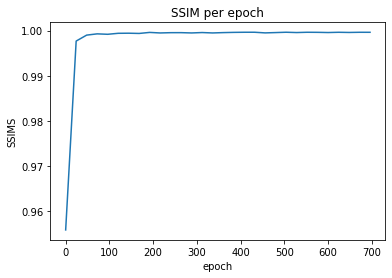

In [50]:
# create a plot of the metrics
plt.plot([metric['epoch'] for metric in metrics], [ ssim.cpu() for ssim in ssims])
plt.xlabel('epoch')
plt.ylabel('SSIMS')
plt.title('SSIM per epoch')

Text(0.5, 1.0, 'FID per epoch')

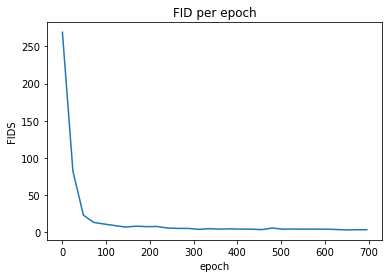

In [51]:
# create a plot of the metrics
plt.plot([metric['epoch'] for metric in metrics], [ fid.cpu() for fid in fids])
plt.xlabel('epoch')
plt.ylabel('FIDS')
plt.title('FID per epoch')

In [55]:
test = [ x for x in test_dataset ]

real = torch.stack([x[0] for x in test], dim=0).to(device)
real = real.unsqueeze(1)
real_fid = ((real + 1) / 2).repeat((1, 3, 1, 1))

psnrs = []
ssims = []
fids = []

print(device)
# Older torchvision doesn't support weights, so use pretrained
inception = models.inception_v3(pretrained=True)
inception.fc = nn.Identity()
fid = FrechetInceptionDistance(model=inception)
    
fake_temp_rc = ((fake + 1) / 2).repeat((1, 3, 1, 1))
print( real_fid.shape     )
print( fake_temp_rc.shape )
    
import torch.nn.functional as F
# Resize to (299, 299) for InceptionV3 compatibility
real_fid     = F.interpolate(real_fid,     size=(299, 299), mode='bilinear', align_corners=False)
fake_temp_rc = F.interpolate(fake_temp_rc, size=(299, 299), mode='bilinear', align_corners=False)

print('loaded fid')
for i in range(100):
    metrics, fake = get_metrics(i)
    fake = fake.to(device)
    
    psnr = PeakSignalNoiseRatio(device=device)
    psnr.update(fake, real)
    psnrs.append(psnr.compute().cpu().numpy())
    
    ssim_sc = ssim(real, fake, size_average=True)
    ssims.append(ssim_sc.cpu().numpy())
    
    # fid = FrechetInceptionDistance()
    fid.update(real_fid, is_real=True)
    fid.update(fake_temp_rc , is_real=False)
    fid_sc = fid.compute()
    fids.append(fid_sc.cpu().numpy())
    
    print(f"{metrics['epoch']}:\t{psnr.compute()} Db;\tssim:{ssim_sc};\tfid_sc:{fid_sc}")

cuda
torch.Size([101, 3, 140, 39])
torch.Size([101, 3, 140, 39])
loaded fid
0:	31.577341079711914 Db;	ssim:0.9995730519294739;	fid_sc:4.417137145996094
1:	31.902511596679688 Db;	ssim:0.999609649181366;	fid_sc:4.40484619140625
2:	31.625364303588867 Db;	ssim:0.9995772838592529;	fid_sc:4.3961944580078125
3:	31.30820083618164 Db;	ssim:0.9995439648628235;	fid_sc:4.3975677490234375
4:	31.860912322998047 Db;	ssim:0.9996035695075989;	fid_sc:4.391551971435547
5:	31.64707374572754 Db;	ssim:0.9995807409286499;	fid_sc:4.393989562988281
6:	31.56147003173828 Db;	ssim:0.9995718598365784;	fid_sc:4.392120361328125
7:	31.781970977783203 Db;	ssim:0.9995976090431213;	fid_sc:4.390300750732422
8:	31.470317840576172 Db;	ssim:0.9995604753494263;	fid_sc:4.389801025390625
9:	31.31565284729004 Db;	ssim:0.9995400905609131;	fid_sc:4.390727996826172
10:	31.796377182006836 Db;	ssim:0.999597430229187;	fid_sc:4.38958740234375
11:	31.554067611694336 Db;	ssim:0.9995715022087097;	fid_sc:4.3877105712890625
12:	31.61887168

In [56]:
for name, metric in zip(['PSNR', 'SSIM', 'FID'], [psnrs, ssims, fids]):
    scores = [ m for m in metric ]
    print(f"{name}:\t{np.mean(scores)} ± {np.std(scores)}")

PSNR:	31.60625648498535 ± 0.16744506359100342
SSIM:	0.9995768666267395 ± 1.8785962311085314e-05
FID:	4.3866987228393555 ± 0.005354016087949276


In [59]:

## !pip install torch-fidelity


In [61]:
'''

from torch_fidelity import calculate_metrics

# This library handles GPU placement automatically
metrics = calculate_metrics(
    input1=real_images,  # or path to real images
    input2=fake_images,  # or path to fake images
    cuda=True,
    isc=True,
    fid=True,
    kid=True,
    verbose=False
)
print(f"FID: {metrics['frechet_inception_distance']}")


'''


'\n\nfrom torch_fidelity import calculate_metrics\n\n# This library handles GPU placement automatically\nmetrics = calculate_metrics(\n    input1=real_images,  # or path to real images\n    input2=fake_images,  # or path to fake images\n    cuda=True,\n    isc=True,\n    fid=True,\n    kid=True,\n    verbose=False\n)\nprint(f"FID: {metrics[\'frechet_inception_distance\']}")\n\n\n'